In [5]:
#!pip install yfinance pandas_datareader

In [6]:
import warnings

warnings.filterwarnings('ignore')

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_datareader as pd_reader

In [8]:
plt.rcParams["figure.figsize"] = (16, 9)

## Getting the Data

In [26]:
# Define the instruments to download. We would like to see Apple, Microsoft and the S&P500 index.
tickers = ['AAPL', 'MSFT', '^GSPC']
tickers = sp_tickers['Symbol'].to_list()

# We would like all available data from 01/01/2000 until 12/31/2016.
start_date = '2018-01-01'
end_date = '2020-12-31'

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
data = pd_reader.data.DataReader(tickers, 'yahoo', start_date, end_date)

#  Get all the companies that are currently in the S&P 500 index today
wiki_table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
sp_tickers = wiki_table[0]

What does `data` look like? data.DataReader returns a Panel object, which can be thought of as a 3D matrix. The first dimension consists of the various fields Yahoo Finance returns for a given instrument, namely, the Open, High, Low, Close and Adj Close prices for each date. The second dimension contain the dates. The third one contains the instrument identifiers.

Let's see what `data` actually is by temporarily making it a dataframe and calling the top nine rows:

In [27]:
data.head(9)

Attributes  Adj Close                                                          \
Symbols             A        AAL         AAP       AAPL       ABBV        ABC   
Date                                                                            
2018-01-02  65.777748  51.647556  104.796822  41.310070  82.956924  88.406036   
2018-01-03  67.451401  51.014027  105.745117  41.302879  84.255081  88.735046   
2018-01-04  66.945419  51.335667  109.646957  41.494736  83.774597  88.537621   
2018-01-05  68.015762  51.316177  110.812576  41.967163  85.232941  89.609322   
2018-01-08  68.161713  50.809345  110.032219  41.811283  83.867310  91.094681   
2018-01-09  69.835342  50.760616  109.143166  41.806496  84.499557  91.677536   
2018-01-10  68.881783  52.417542  109.241966  41.796894  84.035927  91.386078   
2018-01-11  68.891495  54.990665  111.573181  42.034309  84.282143  92.260391   
2018-01-12  69.796410  56.988728  114.526749  42.468365  85.190582  93.068871   

Attributes                                                 ...     Volume  \
Symbols           ABMD        ABT         ACN        ADBE  ...        XEL   
Date                                                       ...              
2018-01-02  192.490005  55.480598  145.921112  177.699997  ...  2443400.0   
2018-01-03  195.820007  55.603271  146.594574  181.039993  ...  4114900.0   
2018-01-04  199.250000  55.508900  148.330338  183.220001  ...  2807000.0   
2018-01-05  202.320007  55.669323  149.553955  185.339996  ...  3728000.0   
2018-01-08  207.800003  55.508900  150.749115  185.039993  ...  3837600.0   
2018-01-09  209.759995  55.603271  151.251831  186.699997  ...  3006300.0   
2018-01-10  208.139999  55.518341  150.720627  187.110001  ...  2690000.0   
2018-01-11  210.149994  55.897629  150.919830  188.919998  ...  3020900.0   
2018-01-12  215.110001  55.793316  151.868347  195.050003  ...  3422600.0   

Attributes                                                                    \
Symbols          XLNX         XOM       XRAY       XYL        YUM        ZBH   
Date                                                                           
2018-01-02  2579900.0  11469300.0  1622300.0  877800.0  1747800.0  1765300.0   
2018-01-03  2453300.0  13957700.0  1533300.0  778800.0  2554900.0  1328800.0   
2018-01-04  3346500.0  10863000.0  1052400.0  796500.0  1971200.0  1073200.0   
2018-01-05  5683500.0  11047600.0  1329000.0  666800.0  1927100.0  1063400.0   
2018-01-08  2483100.0  10927100.0  1188500.0  554700.0  1599400.0  1249500.0   
2018-01-09  1797200.0   8131600.0  2678500.0  687600.0  1701000.0  1999200.0   
2018-01-10  1866100.0  10822300.0  4330500.0  784900.0   887100.0  1956700.0   
2018-01-11  1142800.0  14366000.0  6594900.0  880900.0  1352700.0  1304800.0   
2018-01-12  1063200.0   9834500.0  1667100.0  847700.0  1377300.0  1014400.0   

Attributes                                  
Symbols         ZBRA       ZION        ZTS  
Date                                        
2018-01-02  310600.0  2387100.0  2135600.0  
2018-01-03  253000.0  1575700.0  2328200.0  
2018-01-04  435200.0  3309200.0  2534000.0  
2018-01-05  301800.0  1212200.0  2166100.0  
2018-01-08  218600.0  1697700.0  3631400.0  
2018-01-09  355400.0  1888100.0  2721800.0  
2018-01-10  403000.0  2790500.0  2257200.0  
2018-01-11  493200.0  1242800.0  1629300.0  
2018-01-12  420800.0  1634400.0  1915700.0  

[9 rows x 3030 columns]

## Preparing the Data

Assume we are interested in working with the `adj_close` prices which have been already been adjusted by Yahoo finance to account for stock splits. We want to make sure that all weekdays are included in our dataset, which is very often desirable for quantitative trading strategies.

Of course, some of the weekdays might be public holidays in which case no price will be available. For this reason, we will fill the missing prices with the latest available prices:

In [28]:
# Getting just the adjusted closing prices. This will return a Pandas DataFrame
# The index in this DataFrame is the major index of the panel_data.
close = data['Adj Close']

# Getting all weekdays between 01/01/2000 and 12/31/2016
all_weekdays = pd.date_range(start=start_date, end=end_date, freq='B')

# How do we align the existing prices in `adj_close` with our new set of dates?
# All we need to do is reindex adj_close using all_weekdays as the new index
close = close.reindex(all_weekdays)

# Reindexing will insert missing values (NaN) for the dates that were not present
# in the original set. To cope with this, we can fill the missing by replacing them
# with the latest available price for each instrument.
close = close.fillna(method='ffill')

Initially, `adj_alose` contains all the closing prices for all instruments and all the dates that Yahoo returned. Some of the week days might be missing from the data Google provides. For this reason we create a Series of all the weekdays between the first and last date of interest and store them in the all_weekdays variable. Getting all the weekdays is achieved by passing the `freq=’B’` named parameter to the `pd.date_range()` function. This function return a `DatetimeIndex` which is shown below:

In [29]:
print(all_weekdays)

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-08', '2018-01-09', '2018-01-10',
               '2018-01-11', '2018-01-12',
               ...
               '2020-12-18', '2020-12-21', '2020-12-22', '2020-12-23',
               '2020-12-24', '2020-12-25', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', length=784, freq='B')


Aligning the original DataFrame with the new DatetimeIndex is accomplished by substitution of the initial DatetimeIndex of the `close` DataFrame. If any of the new dates were not included in the original DatetimeIndex, the prices for that date will be filled with `NaN`s. For this reason, we will fill any resulting `NaN`s with the last available price. The final, clean DataFrame is shown below:

In [30]:
close.head(10)

Symbols,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02,65.777748,51.647556,104.796822,41.310070,82.956924,88.406036,192.490005,55.480598,145.921112,177.699997,...,43.540058,64.657593,69.928825,65.382240,65.220093,76.699928,120.948624,103.709999,46.021923,70.275375
2018-01-03,67.451401,51.014027,105.745117,41.302879,84.255081,88.735046,195.820007,55.603271,146.594574,181.039993,...,43.248634,65.953041,71.302231,65.158272,66.015335,76.634125,121.787064,105.769997,45.967468,70.598511
2018-01-04,66.945419,51.335667,109.646957,41.494736,83.774597,88.537621,199.250000,55.508900,148.330338,183.220001,...,42.911682,67.143723,71.400948,65.148529,66.456100,77.414291,121.611588,107.860001,46.158089,71.019547
2018-01-05,68.015762,51.316177,110.812576,41.967163,85.232941,89.609322,202.320007,55.669323,149.553955,185.339996,...,42.611153,70.629974,71.343353,66.063927,66.331535,77.865448,122.820503,109.540001,46.176235,71.832275
2018-01-08,68.161713,50.809345,110.032219,41.811283,83.867310,91.094681,207.800003,55.508900,150.749115,185.039993,...,42.929890,71.096703,71.664085,66.511887,66.571068,77.997055,123.054459,110.629997,45.949306,72.693954
2018-01-09,69.835342,50.760616,109.143166,41.806496,84.499557,91.677536,209.759995,55.603271,151.251831,186.699997,...,42.429016,71.287216,71.359810,63.736477,66.590225,77.790276,121.075378,114.019997,47.029507,73.545845
2018-01-10,68.881783,52.417542,109.241966,41.796894,84.035927,91.386078,208.139999,55.518341,150.720627,187.110001,...,42.010105,70.582352,70.792343,61.116909,66.111160,77.592865,119.457008,114.779999,47.519684,72.370827
2018-01-11,68.891495,54.990665,111.573181,42.034309,84.282143,92.260391,210.149994,55.897629,150.919830,188.919998,...,41.454575,70.810936,71.491386,62.567909,67.040527,77.536476,119.223022,121.169998,48.209553,73.036659
2018-01-12,69.796410,56.988728,114.526749,42.468365,85.190582,93.068871,215.110001,55.793316,151.868347,195.050003,...,41.117622,71.115761,71.976608,64.067581,67.510040,78.598633,119.037781,123.150002,48.363869,73.819992


In [31]:
close.shape

(784, 505)

In [32]:
close.to_csv('all_data.csv', index=False)

## Looking at the Data
Our dataset is now complete and free of missing values. We can see a summary of the values in each of the instrument by calling the `describe()` method of a Pandas DataFrame:

In [15]:
close.describe()

Symbols,AAPL,MSFT,^GSPC
count,4435.000000,4435.000000,4435.000000
mean,8.409074,24.553622,1375.881598
std,9.064218,9.814511,361.308452
min,0.201463,11.554865,676.530029
25%,0.768250,18.200551,1126.334961
50%,4.179437,21.120430,1294.869995
75%,15.420515,25.735246,1507.724976
max,30.333115,59.374153,2271.719971


Suppose we would like to plot the **MSFT time-series**. We would also like to see how the stock behaves compared to a short and longer term moving average of its price.

A simple moving average of the original time-series is calculated by taking for each date the average of the last W prices (including the price on the date of interest). pandas has `rolling()`, a built in function for Series which returns a rolling object for a user-defined window, e.g. 20 days.

Once a rolling object has been obtained, a number of functions can be applied on it, such as `sum()`, `std()` (to calculate the standard deviation of the values in the window) or `mean()`. See below:

In [12]:
# Get the MSFT timeseries. This now returns a Pandas Series object indexed by date.
msft = close.loc[:, 'MSFT']

# Calculate the 20 and 100 days moving averages of the closing prices
short_rolling_msft = msft.rolling(window=20).mean()
long_rolling_msft = msft.rolling(window=100).mean()

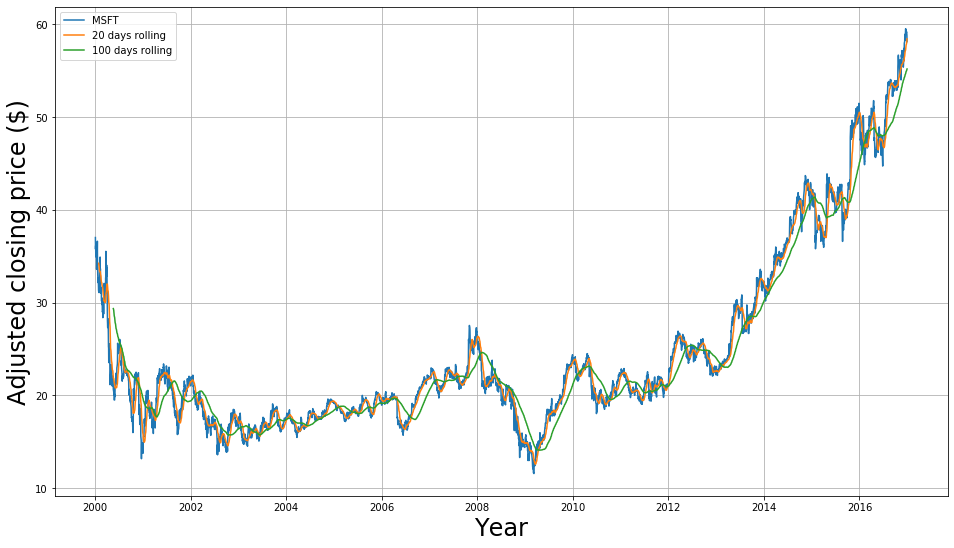

In [13]:
plt.plot(msft.index, msft, label='MSFT')
plt.plot(short_rolling_msft.index, short_rolling_msft, label='20 days rolling')
plt.plot(long_rolling_msft.index, long_rolling_msft, label='100 days rolling')

plt.grid()
plt.xlabel('Year', fontsize=24)
plt.ylabel('Adjusted closing price ($)', fontsize=24)
plt.legend()
plt.show()

Now, we finally the stock price history together with the two moving averages plotted!

In [14]:
sns.set(style='darkgrid', context='talk', palette='Dark2')

We have also calculated the rolling moving averages of these three timeseries as follows. Note that when calculating the $M$ days moving average, the first $M-1$ are not valid, as $M$ prices are required for the first moving average data point.

In [15]:
# Calculating the short-window moving average
short_rolling = close.rolling(window=20).mean()
short_rolling.head()

Symbols,AAPL,MSFT,^GSPC
2000-01-03,NaN,NaN,NaN
2000-01-04,NaN,NaN,NaN
2000-01-05,NaN,NaN,NaN
2000-01-06,NaN,NaN,NaN
2000-01-07,NaN,NaN,NaN


Building on these results, our ultimate goal will be to design a simple yet realistic trading strategy. However, first we need to go through some of the basic concepts related to quantitative trading strategies, as well as the tools and techniques in the process.

## General considerations about trading strategies

There are several ways one can go about when a trading strategy is to be developed. One approach would be to use the price time-series directly and work with numbers that correspond to some monetary value.

For example, a researcher could be working with time-series expressing the price of a given stock. Similarly, if working with fixed income instruments, e.g. bonds, one could be using a time-series expressing the price of the bond as a percentage of a given reference value, in this case the par value of the bond. Working with this type of time-series can be more intuitive as people are used to thinking in terms of prices. However, price time-series have some drawbacks. Prices are usually only positive, which makes it harder to use models and approaches which require or produce negative numbers. In addition, price time-series are usually non-stationary, that is their statistical properties are less stable over time.

An alternative approach is to use time-series which correspond not to actual values but changes in the monetary value of the asset. These time-series can and do assume negative values and also, their statistical properties are usually more stable than the ones of price time-series. The most frequently used forms used are relative returns defined as

$$r_{relative}(t) = \frac{p(t) - p(t-1)}{p(t-1)}$$

and log-returns defined as

$$r_{relative}(t) = \log\frac{p(t) - p(t-1)}{p(t-1)}$$

where $p(t)$ is the price of the asset at time $t$.

There are several reasons why log-returns are being used in the industry and some of them are related to long-standing assumptions about the behaviour of asset returns and are out of our scope. However, what we need to point out are two quite interesting properties. Log-returns are additive and this facilitates treatment of our time-series, relative returns are not. We can see the additivity of log-returns in the following equation.

$$ r(t_1) + r(t_2) = \log\frac{p(t_1)}{p(t_0)} + \log\frac{p(t_2)}{p(t_1)} = \log \frac{p(t_2)}{p(t_0)} $$

Secondly, log-returns are approximately equal to the relative returns for values of $p(t)p(t-1)$ sufficiently close to  1. By taking the first order Taylor expansion of $\log \frac{p(t)}{p(t-1)}$ around 1, we get

$$ \log\frac{p(t)}{p(t-1)} \sim \log 1 + \frac{p(t)}{p(t-1)} - 1 = r_{relative}(t)$$

Both of these are trivially calculated using Pandas:



In [16]:
# Calculating the short-window moving average
long_rolling = close.rolling(window=100).mean()
long_rolling.tail()

Symbols,AAPL,MSFT,^GSPC
2016-12-26,26.346236,54.976674,2176.628792
2016-12-27,26.367527,55.031195,2177.500190
2016-12-28,26.389542,55.084667,2178.244490
2016-12-29,26.411650,55.134711,2178.879189
2016-12-30,26.431019,55.180969,2179.426990


In [17]:
# Relative returns
returns = close.pct_change(1)
returns.head()

Symbols,AAPL,MSFT,^GSPC
2000-01-03,NaN,NaN,NaN
2000-01-04,-0.084310,-0.033781,-0.038345
2000-01-05,0.014633,0.010544,0.001922
2000-01-06,-0.086538,-0.033498,0.000956
2000-01-07,0.047369,0.013068,0.027090


In [18]:
# Log returns - First the logarithm of the prices is taken and the the difference of consecutive (log) observations
log_returns = np.log(close).diff()
log_returns.head()

Symbols,AAPL,MSFT,^GSPC
2000-01-03,NaN,NaN,NaN
2000-01-04,-0.088077,-0.034364,-0.039099
2000-01-05,0.014527,0.010489,0.001920
2000-01-06,-0.090514,-0.034072,0.000955
2000-01-07,0.046281,0.012983,0.026730


Since log-returns are additive, we can create the time-series of cumulative log-returns defined as

$$ c(t) = \sum_{k=1}^{t} r(t)$$
 
The cumulative log-returns and the total relative returns from 2000/01/01 for the three time-series can be seen below. Note that although log-returns are easy to manipulate, investors are accustomed to using relative returns. For example, a log-return of 1 does not mean an investor has doubled the value of his portfolio. A relative return of  $1=100%$  does! Converting between the cumulative log-return $c(t)$ and the total relative return $c_{relative}(t) = \frac{p(t) - p(t_0)}{p(t_0)}$ is simple

$$ c_{relative}(t) = e^{c(t)} - 1 $$

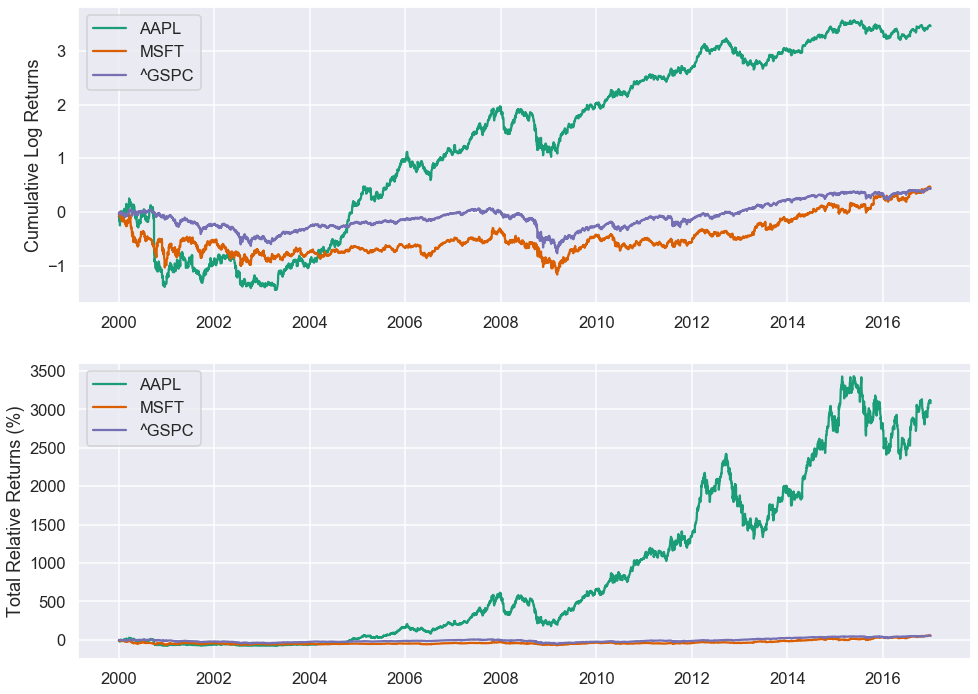

In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,12))

for c in log_returns:
    ax1.plot(log_returns.index, log_returns[c].cumsum(), label=str(c))

ax1.set_ylabel('Cumulative Log Returns')
ax1.legend(loc='best')

for c in log_returns:
    ax2.plot(log_returns.index, 100*(np.exp(log_returns[c].cumsum()) - 1), label=str(c))

ax2.set_ylabel('Total Relative Returns (%)')
ax2.legend(loc='best')

plt.show()

## What is a quantitative trading strategy?

Our goal is to develop a toy trading strategy, but what does the term "quantitative trading strategy" actually mean? In this section we will give a definition that will guide us in our long-term goal.

Assume we have at our disposal a certain amount of dollars, N, which we are interested to invest. We have at our disposal a set of $K$ assets from which we can buy and sell freely any arbitrary amount. Our goal is to derive weights $w_i(t)$ such that

$$ w_i(t)\in \mathbb{R} \text{ and } \sum_{i=1}^{K} w_{i}(t) \le 1$$

so that an amount of dollars equal to $ w_i(t)N$ is invested at time $ t $ on asset $i$.

The inequality condition signifies $\sum_{i=1}^{K} w_i(t) \le 1$ that the maximum amount we can invest is equal to amount of dollars we have, that is $N$.

Note that since we have allowed $w_i(t)$ to be any real number, we are implying that we are allowed to have negative weights. Negative weights imply that we have sold a given asset short. Selling short an asset means selling an asset we do not currently hold and receiving its value in cash. Selling short is different than selling an asset we already own, which is called selling long.

The mechanics behind this can be complicated and are usually subject to regulatory scrutiny. However, on a high level, it involves borrowing the asset from a third party and then selling it to the buyer. Since at some point the asset needs to be returned to the party from which it was borrowed, the short position needs to be closed. This is achieved by buying the asset back from the original buyer or any other willing seller. For the purpose of this article it will be assumed that selling an asset short can be accomplished at no added cost, an assumption which is not true.

The assuming that the weights can be unbounded is not realistic. For example, based on the definition given above we could sell short an amount of AAPL shares of value equal to  𝑁 . This means that, for now, we have at our disposal an additional  𝑁  dollars to invest from the short sale. Thus, together with our original N dollars, we can the purchase shares of MSFT worth  $2N$  dollars. In our framework, this translates to  $w_{AAPL} = -1$  and $w_{MSFT}=2$. In theory, the weights could be  −999  and  1000  respectively. However, an increase in the absolute values of the weights leads to an increase in the risk of our portfolio for reasons we will see further down this series of tutorials. Therefore, when developing our trading strategy, appropriate thresholds will be imposed on the weights $w_i(t)$.

A final note has to do with cash. Any portfolio will at some point in time include cash. In the aforementioned setup if at any point in time $W=\sum_{i=1}^{K}w_i(t) < 1$, then it means that our portfolio includes $(1-W)N$ dollars in cash. Of course, if  $W<0$, our net position is short, which means we are currently holding more than $N$ dollars which is the initial value of the portfolio.

## Putting it all together

In [20]:
r_t = log_returns.tail(1).transpose()
r_t

,2016-12-30
Symbols,
AAPL,-0.007826
MSFT,-0.012156
^GSPC,-0.004648


In [21]:
weights_vector = pd.DataFrame(1 / 3, index=r_t.index, columns=r_t.columns)
weights_vector

,2016-12-30
Symbols,
AAPL,0.333333
MSFT,0.333333
^GSPC,0.333333


In [22]:
portfolio_log_return = weights_vector.transpose().dot(r_t)
portfolio_log_return

,2016-12-30
2016-12-30,-0.00821


In [23]:
weights_matrix = pd.DataFrame(1 / 3, index=close.index, columns=close.columns)
weights_matrix.tail()

Symbols,AAPL,MSFT,^GSPC
2016-12-26,0.333333,0.333333,0.333333
2016-12-27,0.333333,0.333333,0.333333
2016-12-28,0.333333,0.333333,0.333333
2016-12-29,0.333333,0.333333,0.333333
2016-12-30,0.333333,0.333333,0.333333


In [24]:
log_returns.head()

Symbols,AAPL,MSFT,^GSPC
2000-01-03,NaN,NaN,NaN
2000-01-04,-0.088077,-0.034364,-0.039099
2000-01-05,0.014527,0.010489,0.001920
2000-01-06,-0.090514,-0.034072,0.000955
2000-01-07,0.046281,0.012983,0.026730


In [25]:
# Initially the two matrices are multiplied. Note that we are only interested in the diagonal, 
# which is where the dates in the row-index and the column-index match.

temp_var = weights_matrix.dot(log_returns.transpose())
temp_var.head().iloc[:, 0:5]

,2000-01-03,2000-01-04,2000-01-05,2000-01-06,2000-01-07
2000-01-03,NaN,-0.053847,0.008979,-0.04121,0.028665
2000-01-04,NaN,-0.053847,0.008979,-0.04121,0.028665
2000-01-05,NaN,-0.053847,0.008979,-0.04121,0.028665
2000-01-06,NaN,-0.053847,0.008979,-0.04121,0.028665
2000-01-07,NaN,-0.053847,0.008979,-0.04121,0.028665


In [26]:
# The numpy np.diag function is used to extract the diagonal and then
# a Series is constructed using the time information from the log_returns index

portfolio_log_returns = pd.Series(np.diag(temp_var), index=log_returns.index)
portfolio_log_returns.tail()

2016-12-26    0.000000
2016-12-27    0.003070
2016-12-28   -0.005753
2016-12-29   -0.000660
2016-12-30   -0.008210
Freq: B, dtype: float64

Note that these returns are only estimates because of our use of log-returns instead of relative returns. However, for most practical purposes the difference is negligible. Let us see what our cumulative log returns and the total relative returns for this portfolio look.



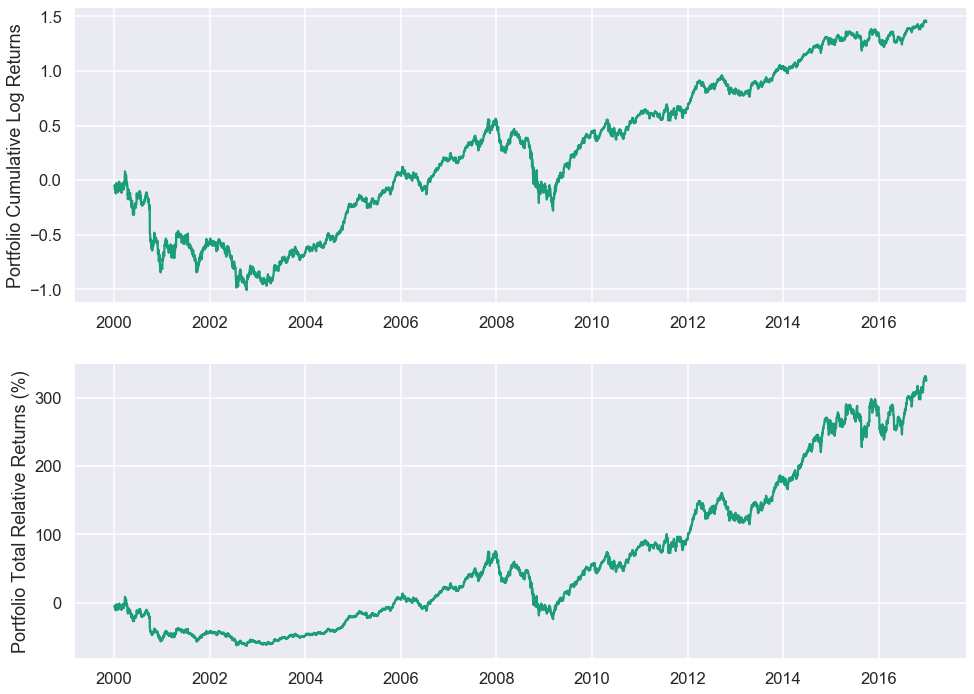

In [27]:
total_relative_returns = (np.exp(portfolio_log_returns.cumsum()) - 1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,12))

ax1.plot(portfolio_log_returns.index, portfolio_log_returns.cumsum())
ax1.set_ylabel('Portfolio Cumulative Log Returns')

ax2.plot(total_relative_returns.index, 100 * total_relative_returns)
ax2.set_ylabel('Portfolio Total Relative Returns (%)')

plt.show()

In [28]:
# Calculating the time-related parameters of the simulation
days_per_year = 52 * 5
total_days_in_simulation = close.shape[0]
number_of_years = total_days_in_simulation / days_per_year

# The last data point will give us the total portfolio return
total_portfolio_return = total_relative_returns[-1]
# Average portfolio return assuming compunding of returns
average_yearly_return = (1 + total_portfolio_return)**(1 / number_of_years) - 1

print('Total portfolio return is: ' + '{:5.2f}'.format(100 * total_portfolio_return) + '%')
print('Average yearly return is: ' + '{:5.2f}'.format(100 * average_yearly_return) + '%')

Total portfolio return is: 325.14%
Average yearly return is:  8.85%
